In [98]:
import os
import glob
import numpy as np
import pandas as pd
from openfermion.ops.operators import FermionOperator
from openfermion.linalg import get_sparse_operator, get_number_preserving_sparse_operator
import scipy.linalg
import matplotlib.pyplot as plt

### Operator Creation from scratch

Creates operators from first principles. Have been checked against the pyvqe output file

In [2]:
def k(p, q):
    pq = FermionOperator("[{}^ {}]".format(q, p)) - FermionOperator("[{}^ {}]".format(p, q))
    return pq


def d(a,b,c,d):
    abcd = FermionOperator("[{}^ {}^ {} {}]".format(a,b,c,d)) - FermionOperator("[{}^ {}^ {} {}]".format(c,d,a,b))
    return abcd


# preparation for fermionoperator
op = []

for p in range(4,-1,-2):
    for q in range(6,p,-2):
        op.append(k(p,q) + k(p+1,q+1))

for p in range(4,-1,-2):
    for q in range(6,p,-2):
        op.append(d(p+1,p,q+1,q))

for i, op_i in enumerate(op):
    print("Operator", i+1)
    print(op_i)

# Output visually checked to be identical to pyvqe output log

Operator 1
-1.0 [4^ 6] +
-1.0 [5^ 7] +
1.0 [6^ 4] +
1.0 [7^ 5]
Operator 2
-1.0 [2^ 6] +
-1.0 [3^ 7] +
1.0 [6^ 2] +
1.0 [7^ 3]
Operator 3
-1.0 [2^ 4] +
-1.0 [3^ 5] +
1.0 [4^ 2] +
1.0 [5^ 3]
Operator 4
-1.0 [0^ 6] +
-1.0 [1^ 7] +
1.0 [6^ 0] +
1.0 [7^ 1]
Operator 5
-1.0 [0^ 4] +
-1.0 [1^ 5] +
1.0 [4^ 0] +
1.0 [5^ 1]
Operator 6
-1.0 [0^ 2] +
-1.0 [1^ 3] +
1.0 [2^ 0] +
1.0 [3^ 1]
Operator 7
1.0 [5^ 4^ 7 6] +
-1.0 [7^ 6^ 5 4]
Operator 8
1.0 [3^ 2^ 7 6] +
-1.0 [7^ 6^ 3 2]
Operator 9
1.0 [3^ 2^ 5 4] +
-1.0 [5^ 4^ 3 2]
Operator 10
1.0 [1^ 0^ 7 6] +
-1.0 [7^ 6^ 1 0]
Operator 11
1.0 [1^ 0^ 5 4] +
-1.0 [5^ 4^ 1 0]
Operator 12
1.0 [1^ 0^ 3 2] +
-1.0 [3^ 2^ 1 0]


In [3]:
op_m = []
# transfer operator to matrix
for i in range(len(op)):
    op_m.append(
        get_number_preserving_sparse_operator(
            op[i], 8, 4,
            spin_preserving=True,
            reference_determinant = None
            ).toarray()
        )

### Operators and ham from file
including inputting data from files and do the calculation and collection for wavefunction after each step and the minimum energy.

In [4]:
# Directory containing operator sequence files
input_directory = r'C:\Users\Alice Ling\Desktop\Summer intern\Coding\replicating energies\H4_linear'

# Reference state (initial wavefunction)
reference_state = np.zeros(36)
reference_state[0] = 1.0  # Modify as needed

# Hamiltonian input
ham = np.fromfile(input_directory + '/ham')
ham = np.reshape(ham,[36,36])

# List of files matching the pattern 'oporder.x.y'
operator_files = glob.glob(os.path.join(input_directory, 'oporder.*.*'))

# Create a Pandas DataFrame to store the results
df = pd.DataFrame(columns=['File', 'Step', 'Operator', 'Coefficient', 'Wavefunction','energy'])
df_energy = pd.DataFrame(columns=['File','Energy'])

# Create an array to hold the wavefunctions for each step
all_wavefunctions_dict = {}

In [5]:
# Iterate through operator files
for operator_file in operator_files:
    x, y = operator_file.split('.')[-2:]
    x = int(x)
    y = int(y)
    
    # Load operator sequence from the file
    operator_sequence = []
    with open(operator_file, 'r') as file:
        for line in file:
            operator_sequence.append(int(line.strip()))
    operator_sequence = operator_sequence [::-1]

    # Read coefficients from 'lowest.x.y.txt' file
    lowest_file = os.path.join(input_directory, f'lowest.{x}.{y}')
    coefficients = []
    with open(lowest_file, 'r') as file:
        lines = file.readlines()[2:]  # Skipping the first 2 rows
        for line in lines:
            coefficients.append(float(line.strip()))
    coefficients = coefficients[::-1]

    # Create a coefficient matrix
    coefficient = np.array(coefficients)

   
    # Apply each operator to the reference state and collect results
    current_state = reference_state.copy()
    wavefunctions_at_each_step = []
    wavefunctions_at_each_step.append(reference_state)
    
    for idx, operator_idx in enumerate(operator_sequence):

        # Try this instead, much neater
        # Adjusted for indexing
        
        if operator_idx > len(op_m):
            raise Exception('{} >= {}'.format(operator_idx, len(op_m)))

        if operator_idx <= 0:
            raise Exception()

        # Apply each operator to the current state and update the arrays
        operator_matrix = coefficient[idx] * op_m[operator_idx - 1]
        operator_exponential = scipy.linalg.expm(operator_matrix)

        # Apply operator to the current state
        current_state = np.matmul(operator_exponential, current_state)

        # Add results to the DataFrame
        df.loc[len(df)] = {
                'File': os.path.basename(operator_file),
                'Step': idx + 1,
                'Operator': operator_idx,
                'Coefficient': coefficient[operator_idx - 1].tolist(),
                'Wavefunction': current_state.tolist(),
                'Energy': None
            }
        
    
        # Collect the current state in the wavefunctions_at_each_step array
        wavefunctions_at_each_step.append(current_state.copy())
        all_wavefunctions_dict.setdefault(operator_file, []).append(current_state.copy())
        # The operator_file name is input_directory + /oporder.x.y
        
    # Extract last value of wavefunction to calculate energy 
    # Note: current_state all real so no need to conjutage
    energy = np.matmul(np.conj(current_state).T, np.matmul(ham, current_state))
    
    # Add the energy to the DataFrame
    df_energy.loc[len(df_energy)] = {
        'File': os.path.basename(operator_file),
        'Energy': energy.tolist()
    }


# Save results to an Excel file
output_excel = 'output_results.xlsx'
output_excel_energy = 'outpyt_energy.xlsx'
df.to_excel(output_excel, index=False)
df_energy.to_excel(output_excel_energy, index=False)



Expected energy: -2.166387449 

### Explaination of forms of wavefunctions:

indicates 36 different states for spin number and symmtry preserving.

the total wavefunction is the sum of coefficient * state

# Visualisation of wavefunctions
try to use a plot to have a look.
e.g. generate the code to visualise what is changed in each step.
and plot a diagram showing the changes.
#### for now, just use oporder.1.1 and lowest.1.1 file to find the ways of visualisation



In [6]:
#wavefunctions only for 'oporder.1.1' file
file_name = r'C:\Users\Alice Ling\Desktop\Summer intern\Coding\replicating energies\H4_linear\oporder.1.1'
wavefunctions_list = all_wavefunctions_dict[file_name]

### Print out the changes for each step

In [7]:
# # Create a DataFrame to store the change information
# change_df = pd.DataFrame(columns=[f'{i + 1}' for i in range(36)])

# # Iterate through the steps and add change information to the DataFrame
# for step, (initial_values, values_after_step) in enumerate(zip(all_wavefunctions_dict[file_name][:-1], all_wavefunctions_dict[file_name][1:]), start=1):
#     changes = np.where((values_after_step != initial_values) & (initial_values != 0) & (values_after_step != 0))[0]
#     change_info = [f'{initial_values[change]:.4f}->{values_after_step[change]:.4f}' if change in changes else '' for change in range(36)]
#     change_df.loc[step] = change_info


# # Save the change information DataFrame to a CSV file
# change_df.to_csv('change_information.csv', index_label='Step')


### use a 2D graph to show the changes in each step

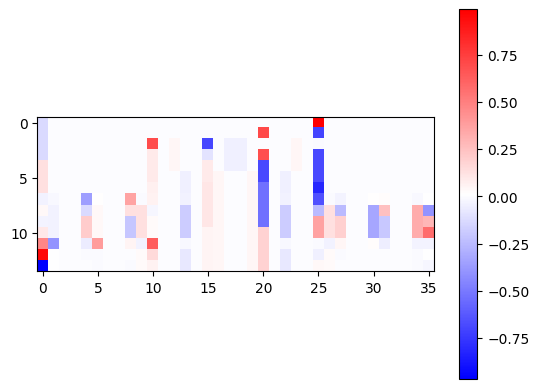

In [8]:
# Trail for only oporder.1.1
wavefuntion = np.array(wavefunctions_list)
plt.imshow(wavefuntion, cmap='bwr')
plt.colorbar()



### do more trails with oporder.1.*


In [9]:
labels = ['[1 1 1 1 0 0 0 0]',
        ' [1 0 1 1 0 1 0 0]',
        ' [1 0 1 1 0 0 0 1]',
        ' [1 1 1 0 0 1 0 0]',
        ' [1 1 1 0 0 0 0 1]',
        ' [0 1 1 1 1 0 0 0]',
        ' [0 1 1 1 0 0 1 0]',
        ' [1 1 0 1 1 0 0 0]',
        ' [1 1 0 1 0 0 1 0]',
        ' [1 0 1 0 0 1 0 1]',
        ' [0 0 1 1 1 1 0 0]',
        ' [0 0 1 1 1 0 0 1]',
        ' [0 1 1 0 1 1 0 0]',
        ' [0 1 1 0 1 0 0 1]',
        ' [0 0 1 1 0 1 1 0]',
        ' [0 0 1 1 0 0 1 1]',
        ' [0 1 1 0 0 1 1 0]',
        ' [0 1 1 0 0 0 1 1]',
        ' [1 0 0 1 1 1 0 0]',
        ' [1 0 0 1 1 0 0 1]',
        ' [1 1 0 0 1 1 0 0]',
        ' [1 1 0 0 1 0 0 1]',
        ' [1 0 0 1 0 1 1 0]',
        ' [1 0 0 1 0 0 1 1]',
        ' [1 1 0 0 0 1 1 0]',
        ' [1 1 0 0 0 0 1 1]',
        ' [0 1 0 1 1 0 1 0]',
        ' [0 0 1 0 1 1 0 1]',
        ' [0 0 1 0 0 1 1 1]',
        ' [1 0 0 0 1 1 0 1]',
        ' [1 0 0 0 0 1 1 1]',
        ' [0 0 0 1 1 1 1 0]',
        ' [0 0 0 1 1 0 1 1]',
        ' [0 1 0 0 1 1 1 0]',
        ' [0 1 0 0 1 0 1 1]',
        ' [0 0 0 0 1 1 1 1]',
]

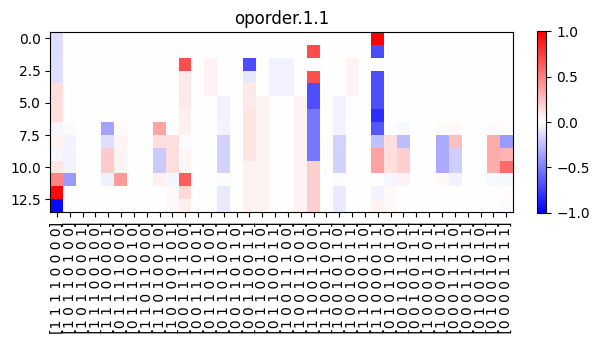

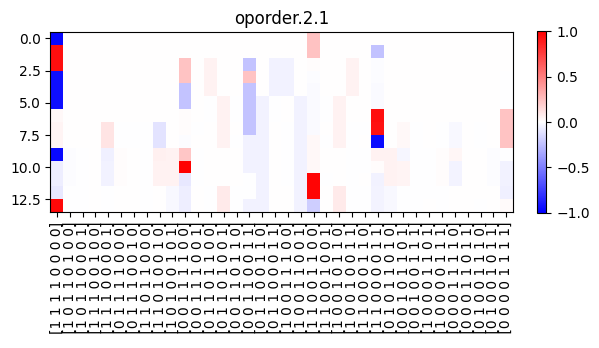

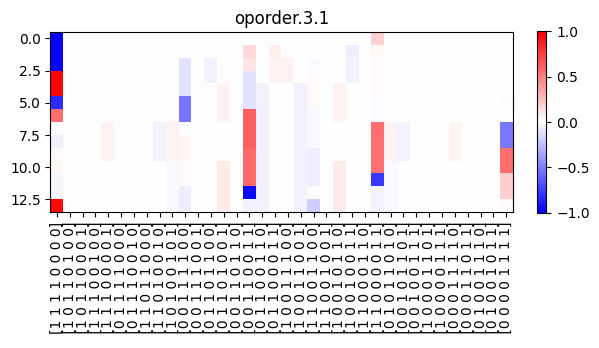

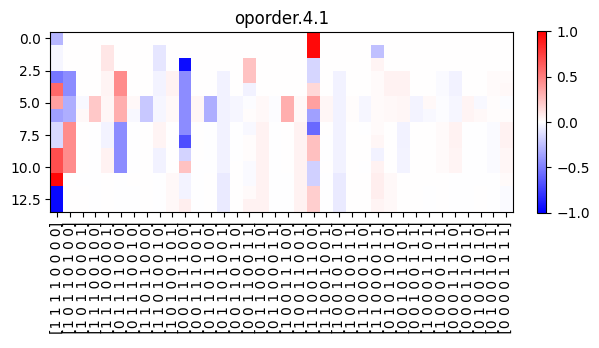

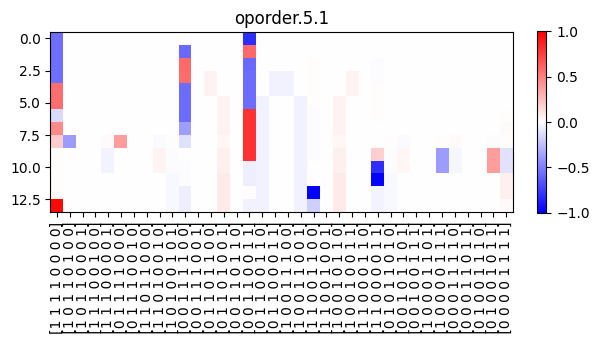

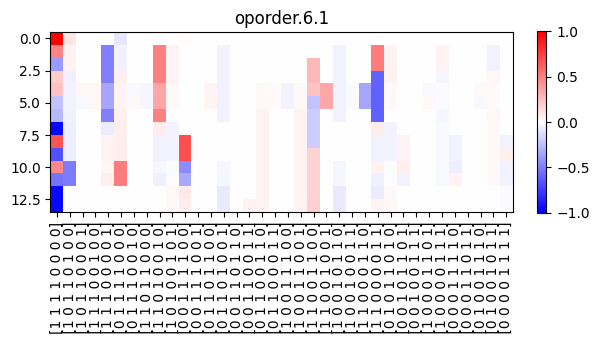

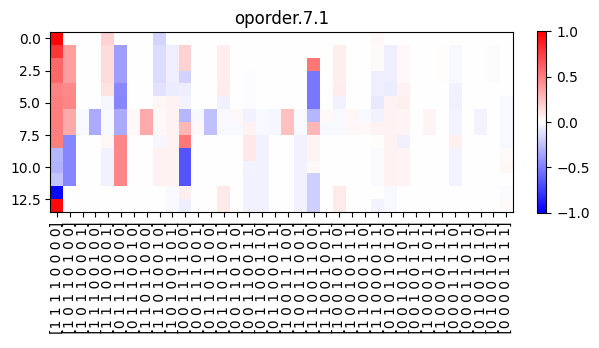

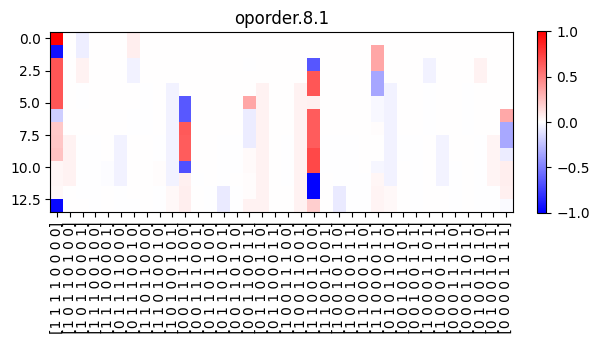

In [10]:
#generate the 2d graphs
#generate the 2d graphs
def pic(file_name):
    wavefunctions_list = all_wavefunctions_dict[file_name]
    wavefuntion = np.array(wavefunctions_list)
    plt.imshow(wavefuntion, cmap='bwr',vmin= -1, vmax=1)
    
    # Calculate im_ratio within the pic function
    im_ratio = wavefuntion.shape[0] / wavefuntion.shape[1]
    
    plt.xticks(range(36), labels, rotation=90)
    
    # Use the calculated im_ratio in the plt.colorbar function call
    plt.colorbar(fraction=0.047 * im_ratio)
    plt.title('oporder.{}.{}'.format(x, y))
    plt.show()

for operator_file in operator_files:
    x, y = operator_file.split('.')[-2:]
    x = int(x)
    y = int(y)
    if y == 1:
        pic(operator_file)


In [11]:
#find number of states at each step
def no_of_states_finder(file_name):
    wavefunctions_list = all_wavefunctions_dict[file_name]
    wavefunctions = np.array(wavefunctions_list)
    # print(wavefunctions)
    counts = []
    counts_exclude = []
    for i, wavefunction in enumerate(wavefunctions):
        count = np.count_nonzero(wavefunction != 0.00000000e+00)
        # print(wavefunction)
        count_exclude = np.count_nonzero(np.logical_and(abs(wavefunction) < 1.00000000e-9, abs(wavefunction) > 0.00000000e+00))
        counts.append(count)
        counts_exclude.append(count_exclude)
        # print(count)
    print(counts)
    print(counts_exclude)
    counts = np.array(counts)
    counts_exclude = np.array(counts_exclude)
    print(counts - counts_exclude)
    return counts, counts_exclude

for operator_file in operator_files:
    x, y = operator_file.split('.')[-2:]
    x = int(x)
    y = int(y)
    if x == 1 and y == 1:
        no_of_states_finder(operator_file)
        

[2, 3, 9, 9, 10, 18, 18, 36, 36, 36, 36, 36, 36, 36]
[0, 0, 0, 0, 1, 9, 9, 16, 16, 16, 16, 16, 16, 16]
[ 2  3  9  9  9  9  9 20 20 20 20 20 20 20]


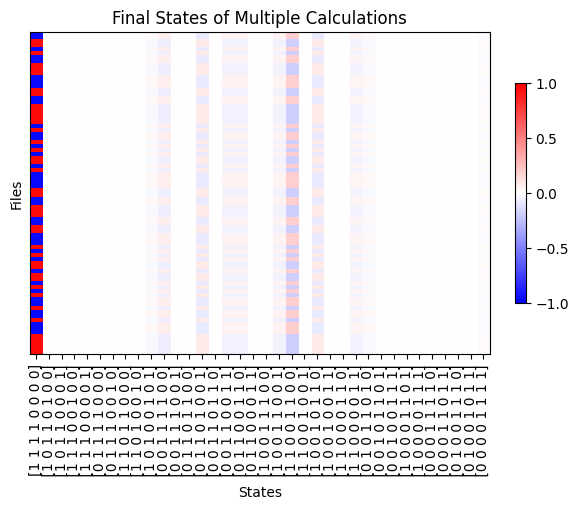

In [104]:
#see if different oporder can find the same state
final_states = []
def final_state_finder(file_name):
    final_states.append(all_wavefunctions_dict[file_name][-1])
    # print(all_wavefunctions_dict[file_name][-1])

for operator_file in operator_files:
    x, y = operator_file.split('.')[-2:]
    x = int(x)
    y = int(y)
    # if y == 1:
    #     print(x,y)
    final_state_finder(operator_file)   
        
final_states_array = np.array(final_states)
plt.imshow(final_states_array, cmap='bwr',vmin= -1, vmax=1)

# Adjust the aspect ratio to control the width of columns
plt.gca().set_aspect(0.7* final_states_array.shape[1] / final_states_array.shape[0])
plt.xticks(range(36), labels, rotation=90)
plt.yticks([])

 
# Calculate (height_of_image / width_of_image)
im_ratio = final_states_array.shape[0]/final_states_array.shape[1]
 
# Plot vertical colorbar
plt.colorbar(fraction = 0.01*im_ratio)
plt.title('Final States of Multiple Calculations')
plt.xlabel('States')
plt.ylabel('Files')
plt.show()



In [50]:
column = ['File','Group','Final State']
df_final_states = pd.DataFrame(columns=column)
for operator_file in operator_files:
    final_state = all_wavefunctions_dict[operator_file][-1]
    operator_file = "r'"+ operator_file + "'"
    # print(final_state)
    if final_state[0] < 0:
        df_final_states.loc[len(df_final_states)] = {
           'File': operator_file,
            'Group': 1,
           'Final State': final_state
       }
    else:
        df_final_states.loc[len(df_final_states)] = {
           'File': operator_file,
            'Group': 2,
           'Final State': final_state
        }
grouped_df_final_states = df_final_states.groupby('Group')['File'].agg(list).reset_index()


In [40]:
#energy reader comparing energies of different data file to see if different oporder can result to same energy
def energy_reading(filename):
    # Read coefficients from 'lowest.x.y.txt' file
    with open(lowest_file,'r') as file:
            lines = file.readlines()[1]
            energy_value = float(lines.split()[3])
            energy_array.append(energy_value)
    return energy_array
    
input_directory_array = [
                        r'C:\Users\Alice Ling\Desktop\Summer intern\Coding\replicating energies\H4_linear']

for input_directory in input_directory_array:
    lowest_files = glob.glob(os.path.join(input_directory, 'lowest.*.*'))
    energy_array = []
    for lowest_file in lowest_files:
        x, y = lowest_file.split('.')[-2:]
        x = int(x)
        y = int(y)
        # if y == 1:
            # print(x,y)
        energy_array = energy_reading(lowest_file)
    print(energy_array)
    


        

[-2.166387449, -2.166387449, -2.166387449, -2.166387449, -2.166387449, -2.166387449, -2.166387449, -2.166387449, -2.166387449, -2.166387449, -2.166387449, -2.166387449, -2.166387449, -2.166387449, -2.166387449, -2.166387449, -2.166387449, -2.166387449, -2.166387449, -2.166387449, -2.166387449, -2.166387449, -2.166387449, -2.166387449, -2.166387449, -2.166387449, -2.166387449, -2.166387449, -2.166387449, -2.166387449, -2.166387449, -2.166387449, -2.166387449, -2.166387449, -2.166387449, -2.166387449, -2.166387449, -2.166387449, -2.166387449, -2.166387449, -2.166387449, -2.166387449, -2.166387449, -2.166387449, -2.166387449, -2.166387449, -2.166387449, -2.166387449, -2.166387449, -2.166387449, -2.166387449, -2.166387449, -2.166387449, -2.166387449, -2.166387449, -2.166387449, -2.166387449, -2.166387449, -2.166387449, -2.166387449, -2.166387449, -2.166387449, -2.166387449, -2.166387449, -2.166387449, -2.166387449, -2.166387449, -2.166387449, -2.166387449, -2.166387449, -2.166387449, -2.16

#### different structures have different energies